# Classifier Trainig

In [32]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import scipy.stats as stats
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from datetime import datetime

# relevant imports
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, GRUCell, LSTM, LSTMCell, RNN, SimpleRNN

from MotionClassifier import MotionClassifier

import sys, os

In [33]:
N_EPOCHS = 500
N_FEATURES = 6 # accel.x, accel.y, accel.z, gyro.x, gyro.y, gyro.z 
SAMPLE_LEN = 400

In [34]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [35]:
tf.config.list_physical_devices('GPU')
if len(tf.config.list_physical_devices('GPU')):
    print("GPU found, hurray =]")

## Read Data

In [36]:

samples= {
    '-':  [],
    'UP':  [],
    'DWN': [],
    'FWD': [],
    'BCK': []
}

label_to_OH = {
    '-':   (1., 0., 0., 0., 0.),
    'UP':  (0., 1., 0., 0., 0.),
    'DWN': (0., 0., 1., 0., 0.),
    'FWD': (0., 0., 0., 1., 0.),
    'BCK': (0., 0., 0., 0., 1.)
}

OH_to_label = {v:k for k,v in label_to_OH.items()}
idx_to_label = {np.argmax(k):v for k,v in OH_to_label.items()}

measurement_file = 'measurements_2024_02_02-10_48_48.csv'

measurement_file_path = os. path.join('C:/','Users','itaym','Documents','limudim','semester_8','robotic_hand_project','data_measurements', measurement_file)
# measurement_file_path = os. path.join('C:/','Users','itay.mal','Documents','robotic_hand_project','data_measurements',measurement_file)

with open(measurement_file_path) as infile:
    _ = infile.readline() # skip headers row
    tmp_empty = []
    while(True):
        l = infile.readline().strip()
        if not l:
            break
        dir = l.rsplit(',',1)[-1]
        if dir in ('UP','DWN','BCK','FWD'):
            tmp = []
            for _ in range(SAMPLE_LEN):
                time, accX, accY, accZ, gyroX, gyroY, gyroZ, _ = infile.readline().strip().split(',')
                tmp.append([float(accX), float(accY), float(accZ), float(gyroX), float(gyroY), float(gyroZ)])
            samples[dir].append(tmp)
        else: # dir is '-'
            time, accX, accY, accZ, gyroX, gyroY, gyroZ, _ = l.split(',')
            tmp_empty.append([float(accX), float(accY), float(accZ), float(gyroX), float(gyroY), float(gyroZ)])
            if len(tmp_empty) == SAMPLE_LEN:
                samples['-'].append(tmp_empty)
                tmp_empty = []

# FIXME: remove hard coded labels here
X = tf.constant(samples['-'] + samples['UP'] + samples['DWN'] + samples['BCK'] + samples['FWD'])
y = tf.constant([label_to_OH['-'] for _ in samples['-']] +
                 [label_to_OH['UP'] for _ in samples['UP']] +
                 [label_to_OH['DWN'] for _ in samples['DWN']] +
                 [label_to_OH['BCK'] for _ in samples['BCK']] +
                 [label_to_OH['FWD'] for _ in samples['FWD']])

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size = 0.2, random_state = 0)

## Data Preview

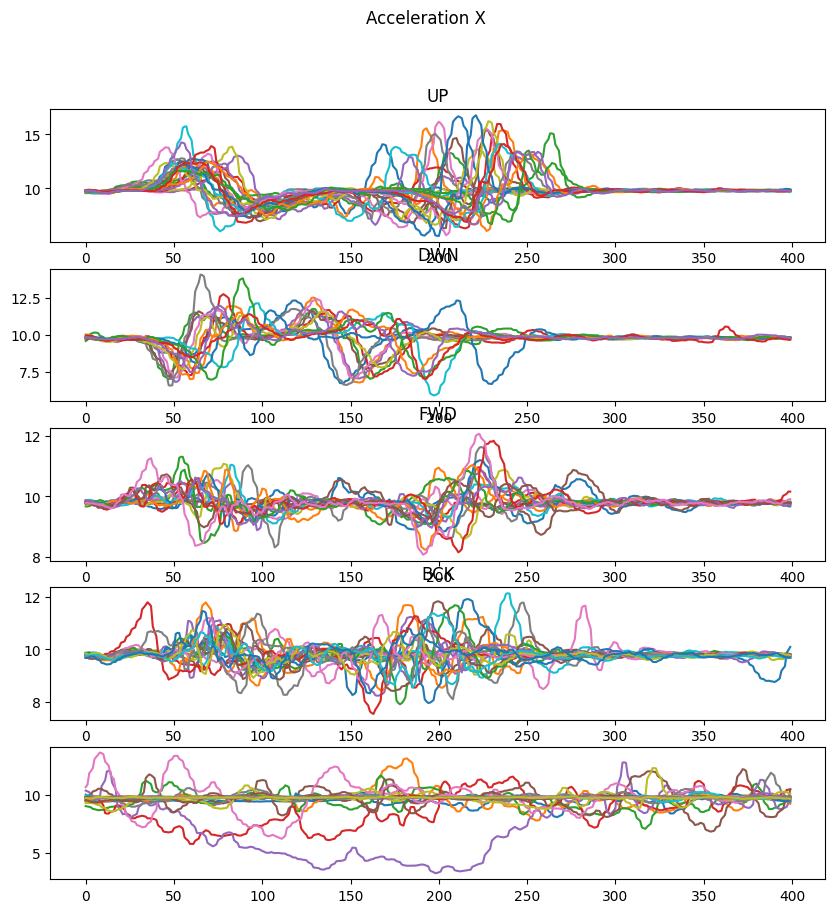

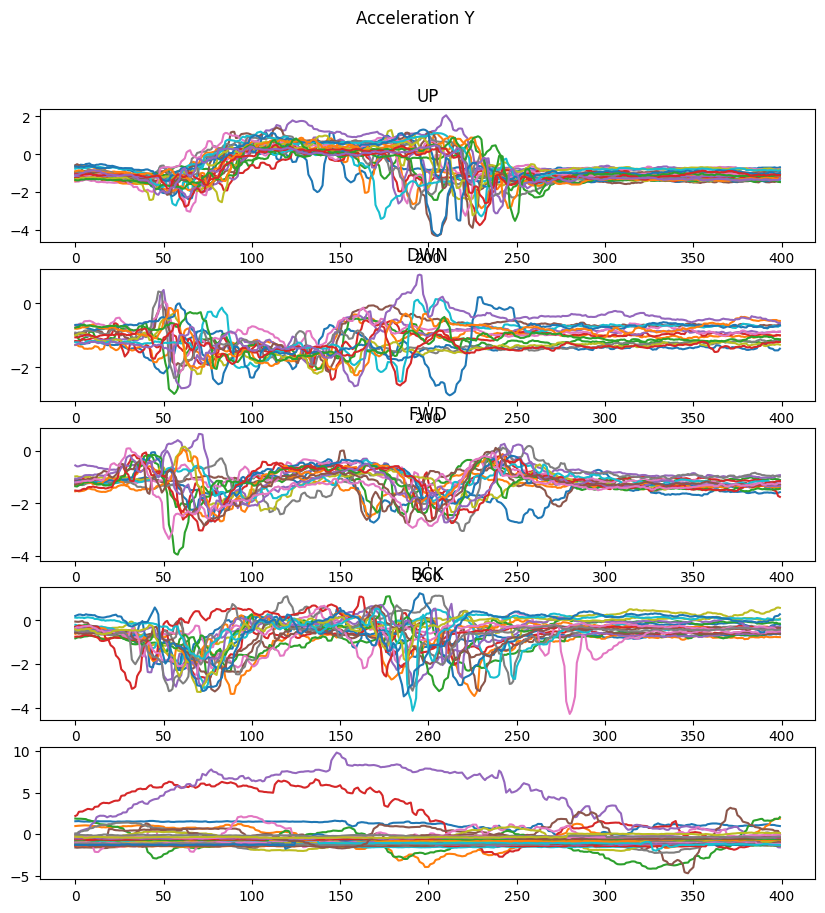

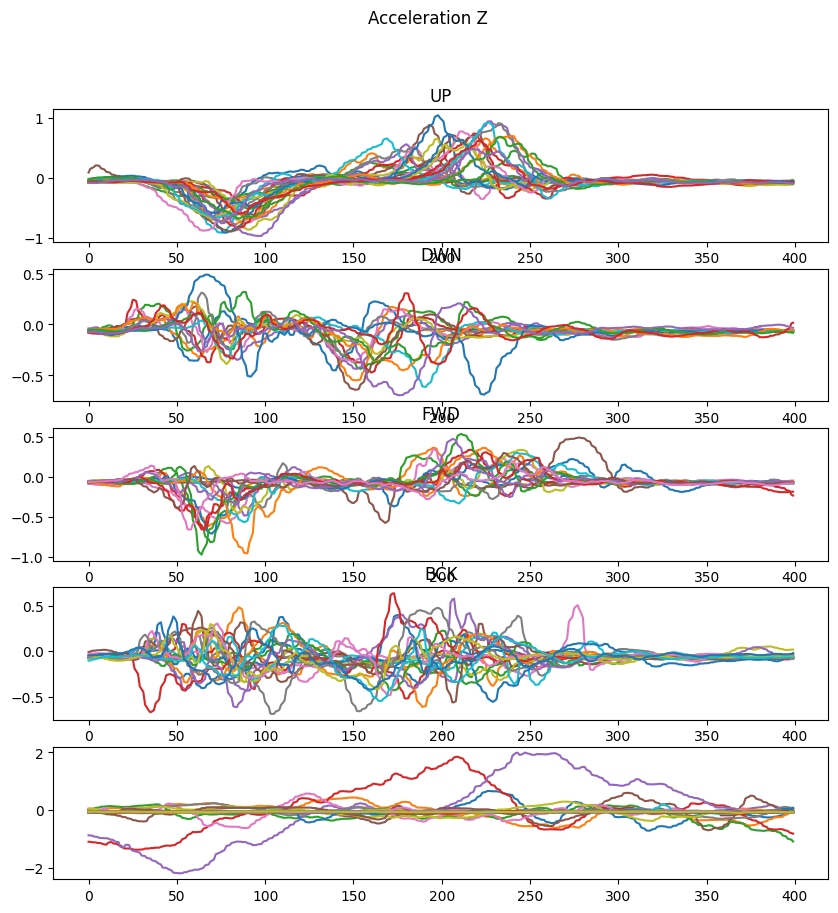

In [37]:
for axes_idx, axes in enumerate(('X','Y','Z')):
    figure = plt.figure(figsize=(10,10))
    figure.suptitle(f'Acceleration {axes}')
    for dir_idx, dir in enumerate(('UP', 'DWN', 'FWD', 'BCK', '-')):
        ax = figure.add_subplot(5,1,dir_idx+1)
        ax.set_title(dir)
        for sam in samples[dir]:
            ax.plot([i[axes_idx+1] for i in sam])

## Define Model

In [38]:
model = MotionClassifier()

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics = ['accuracy'])

## Training

In [39]:
history = model.fit(
    X_train, y_train, epochs=N_EPOCHS, validation_data=(X_test, y_test), verbose=1
)

Epoch 1/500
3/3 [==============================] - 8s 657ms/step - loss: 1.7411 - accuracy: 0.1720 - val_loss: 1.7277 - val_accuracy: 0.2083
Epoch 2/500
3/3 [==============================] - 1s 259ms/step - loss: 1.7182 - accuracy: 0.1720 - val_loss: 1.7055 - val_accuracy: 0.2083
Epoch 3/500
3/3 [==============================] - 1s 232ms/step - loss: 1.6954 - accuracy: 0.1720 - val_loss: 1.6844 - val_accuracy: 0.2083
Epoch 4/500
3/3 [==============================] - 1s 259ms/step - loss: 1.6768 - accuracy: 0.1720 - val_loss: 1.6641 - val_accuracy: 0.2083
Epoch 5/500
3/3 [==============================] - 1s 225ms/step - loss: 1.6599 - accuracy: 0.1935 - val_loss: 1.6449 - val_accuracy: 0.2083
Epoch 6/500
3/3 [==============================] - 1s 225ms/step - loss: 1.6401 - accuracy: 0.1935 - val_loss: 1.6282 - val_accuracy: 0.2083
Epoch 7/500
3/3 [==============================] - 1s 233ms/step - loss: 1.6255 - accuracy: 0.1935 - val_loss: 1.6128 - val_accuracy: 0.2083
Epoch 8/500
3

## Visualize Results

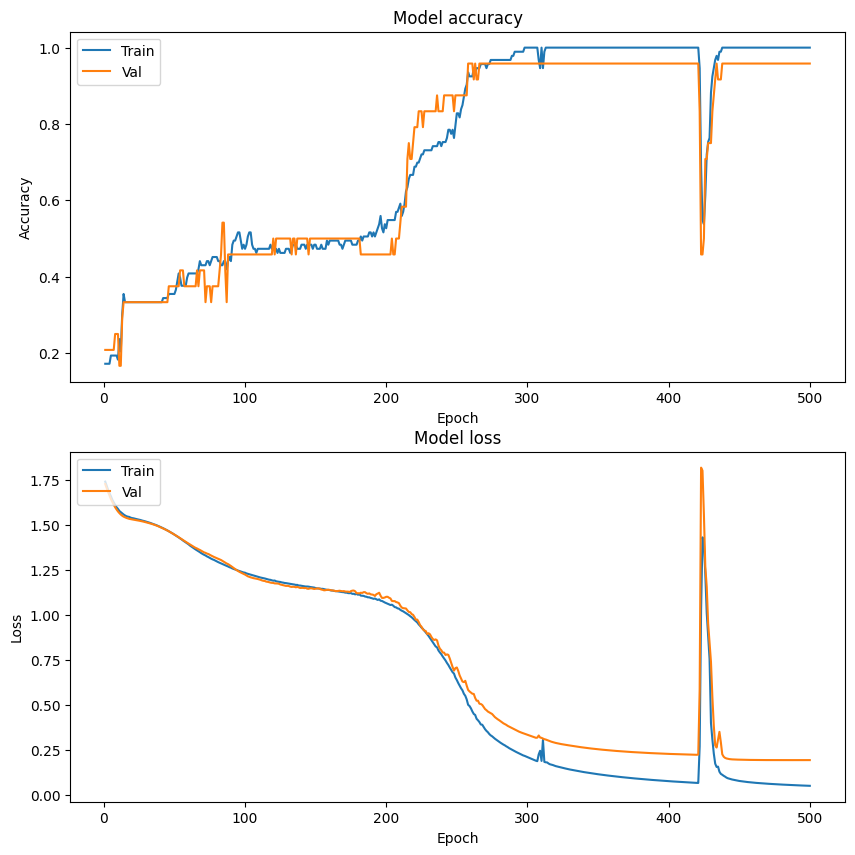

In [40]:
epoch_range = range(1, N_EPOCHS+1)

figure = plt.figure(figsize=(10,10))
ax1 = figure.add_subplot(2,1,1)
ax1.set_title('Model accuracy')
ax1.plot(epoch_range, history.history['accuracy'])
ax1.plot(epoch_range, history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
ax2 = figure.add_subplot(2,1,2)
ax2.plot(epoch_range, history.history['loss'])
ax2.plot(epoch_range, history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='upper left')

1/1 [==============================] - 1s 742ms/step


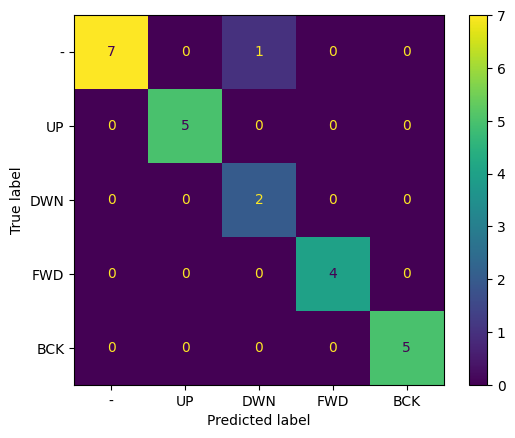

In [41]:
y_true      = []
y_test_pred = []
# there got to be a better way to do this 😞
for i in np.array(y_test):
  y_true.append(OH_to_label[tuple(i)])

for i in np.array(model.predict(X_test)):
  y_test_pred.append(idx_to_label[np.argmax(i)])
  
ConfusionMatrixDisplay.from_predictions(y_true, y_test_pred, labels=list(label_to_OH.keys()))

## Saving Trained Model

In [45]:
# model.save('my_model', include_optimizer=False)
model.save_weights('model_wheights')

In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model('my_model')
# converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

In [44]:
model.summary()
for l in model.layers:
    print(l.name)
    for k in l.weights:
        print(f"\t{k.name} {k.shape}")

Model: "motion_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 multiple                  540       
                                                                 
 gru_3 (GRU)                 multiple                  255       
                                                                 
 dense_1 (Dense)             multiple                  30        
                                                                 
Total params: 825 (3.22 KB)
Trainable params: 825 (3.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
gru_2
	motion_classifier/gru_2/gru_cell/kernel:0 (6, 30)
	motion_classifier/gru_2/gru_cell/recurrent_kernel:0 (10, 30)
	motion_classifier/gru_2/gru_cell/bias:0 (2, 30)
gru_3
	motion_classifier/gru_3/gru_cell/kernel:0 (10, 15)
	motion_classifier/gru_3/gru_cell/recurrent_kernel:0 (5, 